In [138]:
import random
from collections import Counter
import itertools
import math

import networkx as nx
import numpy as np
import pandas as pd
from scipy.special import softmax
from tqdm import trange, tqdm

In [286]:
class Car:
    def __init__(self, id, source, target, created_at_step=0) -> None:
        self.id = id
        self.source = source
        self.target = target
        self.created_at_step = created_at_step

        self.position = (source, source), 1.0 # (v, w), p
        self.route = [source]

    def __repr__(self) -> str:
        (v, w), p = self.position
        return f'<Car {self.id} ({self.source} -> {self.target}) at {p} of {(v, w)}>'

    def act(self, network):
        current_node = self.position[0][1]
        if current_node == self.target or not nx.has_path(network, current_node, self.target):
            return current_node
        else:
            choice = random.choice(list(nx.all_shortest_paths(network, current_node, self.target, weight='anticipated_latency')))[1]
            print(f'Car {self.id} at {current_node} chooses {choice}.')

            self.route.append(choice)
            return choice

    def reset(self, source, step):
        self.source = source
        self.created_at_step = step

        self.position = (source, source), 1.0 # (v, w), p
        self.route = [source]
            

class TrafficModel:
    def __init__(self, network, cars) -> None:
        self.network = network
        self.cars = cars

    def update_latencies(self):
        nx.set_edge_attributes(self.network, {(v, w): attr['latency_fn'](attr['flow']) for v, w, attr in self.network.edges(data=True)}, 'latency')
        nx.set_edge_attributes(self.network, {(v, w): attr['latency_fn'](attr['flow'] + 1) for v, w, attr in self.network.edges(data=True)}, 'anticipated_latency')

    def update_latency(self, edge):
        self.network.edges[edge]['latency'] = self.network.edges[edge]['latency_fn'](self.network.edges[edge]['flow'])
        self.network.edges[edge]['anticipated_latency'] = self.network.edges[edge]['latency_fn'](self.network.edges[edge]['flow'] + 1)

    @property
    def allowed_network(self):
        return nx.restricted_view(self.network, [], [(v, w) for v, w, allowed in self.network.edges(data='allowed') if not allowed])

In [323]:
def run(model, number_of_steps):
    # Let all cars which are at a node decide where to go first
    nx.set_edge_attributes(model.network, Counter(car.position[0] for car in model.cars.values() if car.position[1] < 1.0), 'flow')
    model.update_latencies()
    
    for car in np.random.permutation([car for car in model.cars.values() if car.position[1] == 1.0]):
        car.position = (car.position[0][1], car.act(model.allowed_network)), 0.0
        model.network.edges[car.position[0]]['flow'] += 1
        model.update_latency(car.position[0])

    flow = []
    latency = []
    stats = []
    for step in range(number_of_steps):
        print(f'Step {step}:')

        flow.append(nx.get_edge_attributes(model.network, 'flow'))
        latency.append(nx.get_edge_attributes(model.network, 'latency'))

        # Advance cars and track cars which have reached a node
        actionable_cars = []
        for car in model.cars.values():
            car.position = (car.position[0], min(car.position[1] + 1.0 / model.network.edges[car.position[0]]['latency'], 1.0))
            if car.position[1] == 1.0:
                actionable_cars.append(car)
                model.network.edges[car.position[0]]['flow'] -= 1
        
        # Update latencies
        model.update_latencies()

        # Let actionable car choose next edge
        for car in np.random.permutation(actionable_cars):
            car.position = (car.position[0][1], car.act(model.allowed_network)), 0.0
            model.network.edges[car.position[0]]['flow'] += 1
            model.update_latency(car.position[0])

        for car in model.cars.values():
            if car.position[0][0] == car.target:
                stats.append({'source': car.source, 'target': car.target, 'steps': step - car.created_at_step, 'route': tuple(car.route)})
                print(f'Car {car.id} reached its target after {step - car.created_at_step} steps.')

                model.network.edges[car.position[0]]['flow'] -= 1

                source = np.random.randint(3)
                car.reset(source, step)

                model.network.edges[car.position[0]]['flow'] += 1
                model.update_latency(car.position[0])

    return pd.DataFrame(flow), pd.DataFrame(latency), pd.DataFrame(stats)

In [354]:
network = nx.DiGraph([(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)])

node_positions = {
    0: np.array([0, 0]),
    1: np.array([0.33, 0]),
    2: np.array([0.66, 0]),
    3: np.array([1, 0])
}

nx.set_node_attributes(network, node_positions, 'position')

# Latency is defined in terms of the load, i.e., the number of cars on the road
latency_fns = {
    (0, 0): lambda n: 1,
    (0, 1): lambda n: n,
    (0, 2): lambda n: 11,
    (1, 1): lambda n: 1,
    (1, 2): lambda n: 1,
    (1, 3): lambda n: 11,
    (2, 2): lambda n: 1,
    (2, 3): lambda n: n,
    (3, 3): lambda n: 1
}

nx.set_edge_attributes(network, latency_fns, 'latency_fn')

nx.set_edge_attributes(network, 0, 'flow')
nx.set_edge_attributes(network, 0, 'utilization')

nx.set_edge_attributes(network, True, 'allowed')

number_of_cars = 16
cars = {id: Car(id, source, 3) for id, source in zip(range(number_of_cars), np.random.randint(3, size=number_of_cars))}

model = TrafficModel(network, cars)

In [355]:
model.network[1][2]['allowed'] = True
flow, latency, stats = run(model, 10000)

Car 6 at 2 chooses 3.
Car 12 at 2 chooses 3.
Car 9 at 1 chooses 2.
Car 5 at 2 chooses 3.
Car 2 at 2 chooses 3.
Car 7 at 0 chooses 1.
Car 0 at 2 chooses 3.
Car 13 at 0 chooses 1.
Car 3 at 0 chooses 1.
Car 4 at 0 chooses 1.
Car 14 at 1 chooses 2.
Car 8 at 0 chooses 1.
Car 15 at 2 chooses 3.
Car 1 at 0 chooses 1.
Car 10 at 2 chooses 3.
Car 11 at 0 chooses 1.
Step 0:
Car 14 at 2 chooses 3.
Car 9 at 2 chooses 3.
Step 1:
Step 2:
Step 3:
Step 4:
Step 5:
Step 6:
Step 7:
Car 1 at 1 chooses 2.
Car 8 at 1 chooses 3.
Car 13 at 1 chooses 2.
Car 11 at 1 chooses 2.
Car 4 at 1 chooses 2.
Car 7 at 1 chooses 2.
Car 3 at 1 chooses 3.
Step 8:
Car 7 at 2 chooses 3.
Car 13 at 2 chooses 3.
Car 4 at 2 chooses 3.
Car 11 at 2 chooses 3.
Car 1 at 2 chooses 3.
Car 0 reached its target after 8 steps.
Car 2 reached its target after 8 steps.
Car 5 reached its target after 8 steps.
Car 6 reached its target after 8 steps.
Car 10 reached its target after 8 steps.
Car 12 reached its target after 8 steps.
Car 15 reached 

In [356]:
stats.groupby('route').count()

,source,target,steps
route,,,
"(0, 1, 2, 3)",2320,2320,2320
"(0, 1, 3)",1935,1935,1935
"(0, 2, 3)",1,1,1
"(1, 2, 3)",2807,2807,2807
"(1, 3)",1501,1501,1501
"(2, 3)",4318,4318,4318


<Axes: >

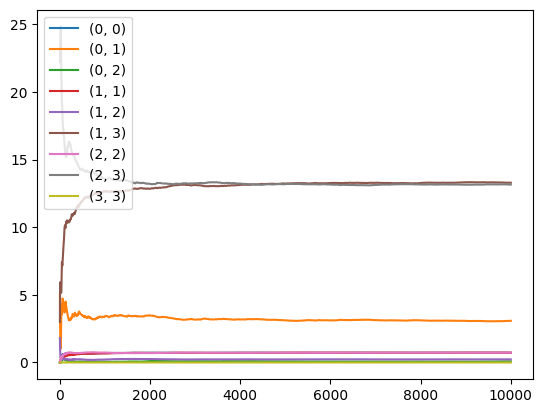

In [350]:
flow.expanding(5).mean().plot()

<Axes: >

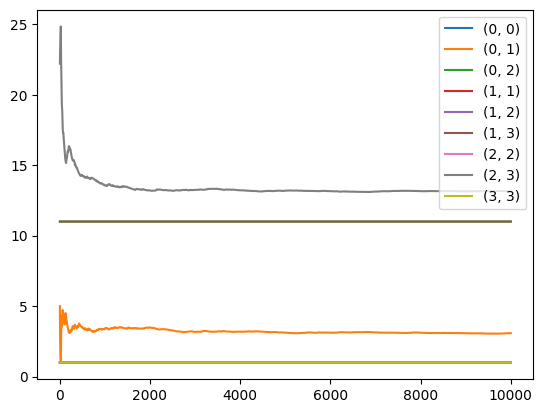

In [351]:
latency.expanding(5).mean().plot()